In [68]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

df  = pd.read_csv("../ETL/iot_agriculture_clean.csv")
df["date"] = pd.to_datetime(df["date"], errors='coerce')



# 1 Preparacion: Target Futuro

In [69]:
#==== Variables ====

humedad_futura = "humidity_future"
regla_de_riego ="regla_de_riego"
prediccion_humedad ='predicted_humidity'
humedad = "humidity"
target_agua_objetivo  ="target_water_future"
riego_real = "watering_real"
riego_clasificador = "watering_clf"


In [70]:
#==== Target de regresión futura ====
df[humedad_futura] = df[humedad].shift(-1)
df_reg = df.dropna()

features_regressionLinear = ['humidity', 'tempreature', 'N', 'P', 'K', 'NPK_index', 'hour', 'is_weekend']
X_regressionLinear = df_reg[features_regressionLinear]
y_regressionLinear = df_reg[humedad_futura]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regressionLinear, y_regressionLinear, test_size=0.2, random_state=42) 


# 2  Modelo de Regresion

In [71]:
#==== Modelo regresión ====
linearRegression_model = LinearRegression()
linearRegression_model.fit(X_train_reg, y_train_reg)
y_predict_reg = linearRegression_model.predict(X_test_reg)
# Limitar predicciones al rango físico 0-1
y_predict_reg = np.clip(y_predict_reg, 0, 1)


print("MAE:", mean_absolute_error(y_test_reg, y_predict_reg))
print("RMSE:", sqrt(mean_squared_error(y_test_reg, y_predict_reg))) 

MAE: 0.043091274770514644
RMSE: 0.10204239788490835


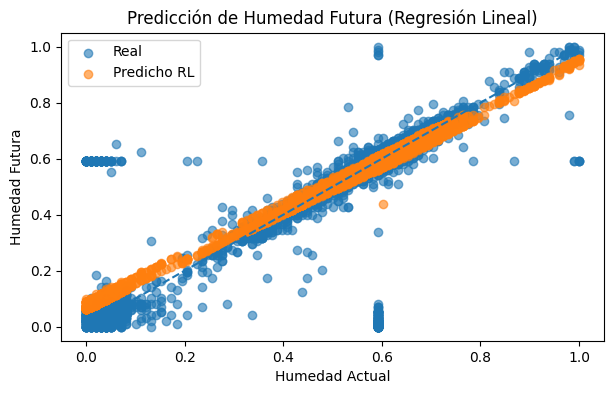

In [72]:
plt.figure(figsize=(7,4))

# Real vs Predicho
plt.scatter(X_test_reg['humidity'], y_test_reg, label="Real", alpha=0.6)
plt.scatter(X_test_reg['humidity'], y_predict_reg, label="Predicho RL", alpha=0.6)

# Línea ideal
lims = [0,1]
plt.plot(lims, lims, "--")

plt.xlabel("Humedad Actual")
plt.ylabel("Humedad Futura")
plt.title("Predicción de Humedad Futura (Regresión Lineal)")
plt.legend()
plt.show()


In [73]:
# -------------------------------
# 3️ Simulación de humedad variada (para tener casos 0 y 1)
# -------------------------------

df_iot = X_test_reg.copy()
df_iot['hour'] = X_test_reg['hour'].values

np.random.seed(42)
df_iot[prediccion_humedad] = y_predict_reg + np.random.normal(0, 0.1, size=len(y_predict_reg))
df_iot[prediccion_humedad] = df_iot[prediccion_humedad].clip(0,1)
df_iot[humedad] = X_test_reg[humedad]

# 3 Regla de Negocio
    SI HUMEDAD PREDICHA < 30% --> ENCENDER BOMBA

In [74]:
# Creamos la columna regla_de_riego para crear las etiquetas [0,1]
df_iot[regla_de_riego] = (df_iot[prediccion_humedad] < 0.3).astype(int)


In [75]:
df_iot

,humidity,tempreature,N,P,K,NPK_index,hour,is_weekend,predicted_humidity,regla_de_riego
25874,0.581633,0.236842,1.000000,1.000000,1.000000,1.000000,20,0,0.610707,0
33381,0.602041,0.684211,1.000000,1.000000,1.000000,1.000000,3,0,0.563034,0
33445,0.622449,0.421053,1.000000,1.000000,1.000000,1.000000,9,0,0.663111,0
28814,0.581633,0.789474,1.000000,1.000000,1.000000,1.000000,6,1,0.717921,0
29627,0.612245,0.684211,1.000000,1.000000,1.000000,1.000000,2,0,0.562931,0
...,...,...,...,...,...,...,...,...,...,...
8238,0.153061,0.605263,0.698039,0.729412,0.615686,0.681046,1,0,0.079369,1
2104,0.704082,0.394737,0.725490,0.745098,0.627451,0.699346,12,0,0.810689,0
2292,0.724490,0.605263,0.725490,0.745098,0.627451,0.699346,6,0,0.773535,0
10476,0.683673,0.289474,0.698039,0.729412,0.615686,0.681046,13,0,0.672214,0


# 4 Clasificador Inteligente 

In [76]:
#==== Modelo clasificador ====
features_clf = ['humidity', 'N', 'P', 'K', 'NPK_index', 'is_weekend']
clf = RandomForestClassifier(random_state=42, n_estimators=200)

df[target_agua_objetivo] = (df[humedad_futura] < 0.3).astype(int)

X_clf = df[features_clf]
y_clf = df[target_agua_objetivo]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42)

clf.fit(X_train_clf, y_train_clf)

df_iot[riego_clasificador] = clf.predict(df_iot[features_clf])


In [77]:
df_iot[riego_real] = (df_iot[humedad] < 0.3).astype(int)



# 5 Realidad simulada (verdad)


In [78]:
#==== Realidad (verdad del sistema) ====
df_iot[riego_real] = (df_iot[humedad] < 0.3).astype(int)


In [79]:
# --------------------------
# Tabla comparativa (IoT rule vs RL vs RF) - usa tus nombres
# --------------------------
df_compare = pd.DataFrame({
    "humidity_real": df_iot[humedad].values,
    "humidity_pred_RL": df_iot[prediccion_humedad].values,
    "watering_real": df_iot["watering_real"].values,
    "water_rule_IoT": df_iot[regla_de_riego].values,
    "water_RF": df_iot[riego_clasificador].values
})

print("\nTabla comparativa (primeras 10 filas):")
print(df_compare.head(10))


Tabla comparativa (primeras 10 filas):
   humidity_real  humidity_pred_RL  watering_real  water_rule_IoT  water_RF
0       0.581633          0.610707              0               0         0
1       0.602041          0.563034              0               0         0
2       0.622449          0.663111              0               0         0
3       0.581633          0.717921              0               0         0
4       0.612245          0.562931              0               0         0
5       0.591837          0.543070              0               0         0
6       0.081633          0.294931              1               1         1
7       0.020408          0.165342              1               1         1
8       0.591837          0.552460              0               0         0
9       0.571429          0.634108              0               0         0


In [80]:
# --------------------------
# Métricas
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Regla simple vs Realidad")
print(classification_report(df_iot[riego_real], df_iot[regla_de_riego]))
print(confusion_matrix(df_iot[riego_real], df_iot[regla_de_riego]))

print("\n📊 RandomForest vs Realidad")
print(classification_report(df_iot[riego_real], df_iot[riego_clasificador]))
print(confusion_matrix(df_iot[riego_real], df_iot[riego_clasificador]))


📊 Regla simple vs Realidad
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6416
           1       0.92      0.94      0.93      1168

    accuracy                           0.98      7584
   macro avg       0.96      0.96      0.96      7584
weighted avg       0.98      0.98      0.98      7584

[[6326   90]
 [  75 1093]]

📊 RandomForest vs Realidad
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6416
           1       1.00      0.99      0.99      1168

    accuracy                           1.00      7584
   macro avg       1.00      0.99      1.00      7584
weighted avg       1.00      1.00      1.00      7584

[[6412    4]
 [  12 1156]]


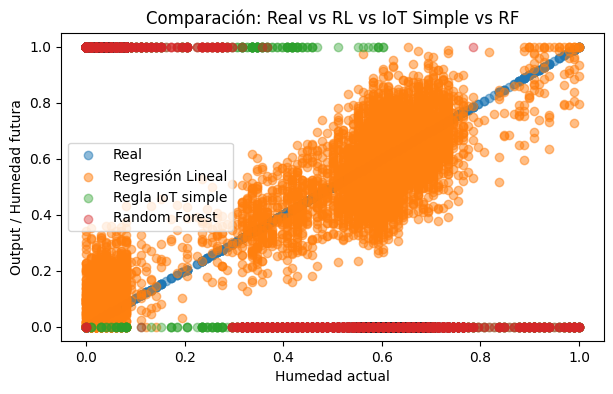

In [81]:
plt.figure(figsize=(7,4))

# Real (humedad real contra sí misma)
plt.scatter(df_iot['humidity'], df_iot['humidity'], 
            label="Real", alpha=0.5)

# Predicción Regresión Lineal
plt.scatter(df_iot['humidity'], df_iot['predicted_humidity'], 
            label="Regresión Lineal", alpha=0.5)

# Regla IoT simple (usa tu nombre real de columna)
plt.scatter(df_iot['humidity'], df_iot['regla_de_riego']*1, 
            label="Regla IoT simple", alpha=0.4)

# Random Forest
plt.scatter(df_iot['humidity'], df_iot['watering_clf']*1, 
            label="Random Forest", alpha=0.4)

plt.xlabel("Humedad actual")
plt.ylabel("Output / Humedad futura")
plt.title("Comparación: Real vs RL vs IoT Simple vs RF")
plt.legend()
plt.show()


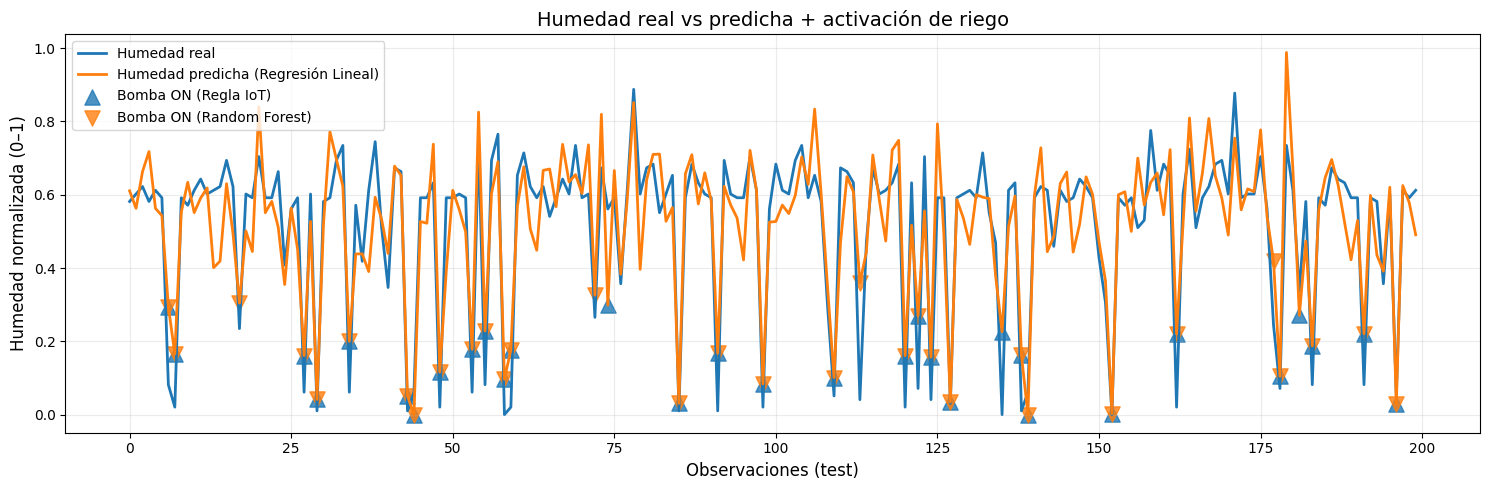

In [82]:
# Tomamos las primeras 200 observaciones para visualizar
n_obs = 200

y_real = df_iot['humidity'].values[:n_obs]
y_pred = df_iot['predicted_humidity'].values[:n_obs]

# Regla IoT simple
watering_rule = df_iot['regla_de_riego'].values[:n_obs]

# Clasificador RF
watering_rf = df_iot['watering_clf'].values[:n_obs]

plt.figure(figsize=(15,5))

# Humedad real y predicha
plt.plot(y_real, label='Humedad real', linewidth=2)
plt.plot(y_pred, label='Humedad predicha (Regresión Lineal)', linewidth=2)

# Activaciones por regla simple
plt.scatter(
    np.arange(n_obs)[watering_rule==1], 
    y_pred[watering_rule==1], 
    marker='^', s=120, label='Bomba ON (Regla IoT)', alpha=0.8
)

# Activaciones por RF (clasificador inteligente)
plt.scatter(
    np.arange(n_obs)[watering_rf==1], 
    y_pred[watering_rf==1], 
    marker='v', s=120, label='Bomba ON (Random Forest)', alpha=0.8
)

plt.title("Humedad real vs predicha + activación de riego", fontsize=14)
plt.xlabel("Observaciones (test)", fontsize=12)
plt.ylabel("Humedad normalizada (0–1)", fontsize=12)
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
 

# Laboratorio de Prueba


Resultados del laboratorio de pruebas:
              case  humidity  predicted_humidity_RL  rule_IoT  RF_decision
        normal_low      0.25              -0.111643         1            1
        normal_mid      0.45               0.261513         1            0
       normal_high      0.65               0.138107         1            0
       extreme_low      0.02              -0.802452         1            1
               low      0.18              -0.818900         1            1
         very_high      0.95               0.147370         1            0
              high      0.80               0.273803         1            0
   weird_temp_high      0.50              -0.912750         1            0
    weird_temp_low      0.50               0.789463         0            0
       missing_NPK      0.30              -0.407439         1            0
 percent_input_low      0.30              -0.366597         1            0
percent_input_high      0.80              -0.023108         

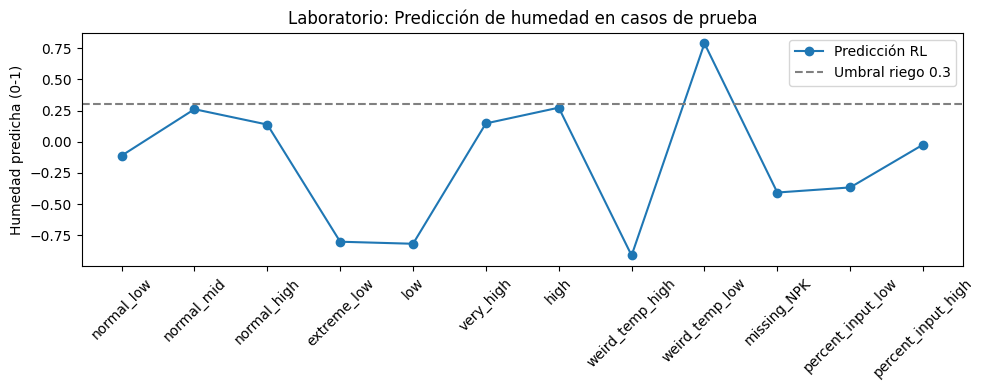

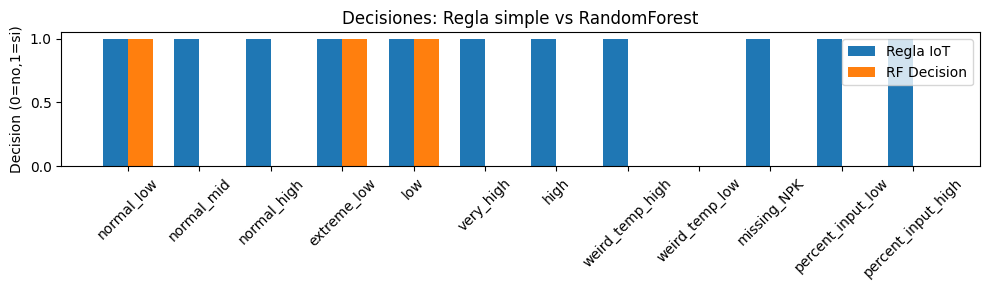


Ejemplo prueba rápida (puedes modificar 'ej'):
{'humidity': 15, 'tempreature': 25, 'N': 20, 'P': 18, 'K': 18, 'NPK_index': 0.7, 'hour': 10, 'is_weekend': 0} -> {'pred_humidity_RL': np.float64(-0.36664071032858164), 'rule_IoT': 1, 'RF_decision': 1}


In [83]:
# -------------------------------
# LABORATORIO DE PRUEBAS (normal / extremo / atípico)
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helpers: asegurar que los nombres de features existan ---
# Si tus listas no están definidas por alguna razón, las creamos desde el df
try:
    features_reg = features_regressionLinear
except NameError:
    features_reg = ['humidity', 'tempreature', 'N', 'P', 'K', 'NPK_index', 'hour', 'is_weekend']

try:
    features_clf_local = features_clf
except NameError:
    features_clf_local = ['humidity', 'N', 'P', 'K', 'NPK_index', 'is_weekend']

# --- Función para normalizar humedad si la pasás en % (30 => 0.30) ---
def normalize_h(h):
    if h is None: 
        return np.nan
    try:
        h = float(h)
    except:
        return np.nan
    return h/100.0 if h > 1.5 else h  # si >1.5 asumimos porcentaje

# --- Casos de prueba predefinidos ---
test_cases = [
    # normales
    {'case':'normal_low','humidity':normalize_h(0.25),'tempreature':20,'N':20,'P':18,'K':18,'NPK_index':0.6,'hour':9,'is_weekend':0},
    {'case':'normal_mid','humidity':normalize_h(0.45),'tempreature':22,'N':25,'P':20,'K':20,'NPK_index':0.7,'hour':12,'is_weekend':0},
    {'case':'normal_high','humidity':normalize_h(0.65),'tempreature':24,'N':30,'P':22,'K':24,'NPK_index':0.8,'hour':16,'is_weekend':0},

    # bajos / riesgo de sequía
    {'case':'extreme_low','humidity':normalize_h(0.02),'tempreature':28,'N':10,'P':10,'K':10,'NPK_index':0.3,'hour':14,'is_weekend':0},
    {'case':'low','humidity':normalize_h(0.18),'tempreature':26,'N':15,'P':12,'K':14,'NPK_index':0.4,'hour':11,'is_weekend':0},

    # altos / encharcamiento
    {'case':'very_high','humidity':normalize_h(0.95),'tempreature':19,'N':40,'P':35,'K':38,'NPK_index':0.95,'hour':6,'is_weekend':1},
    {'case':'high','humidity':normalize_h(0.8),'tempreature':18,'N':35,'P':30,'K':32,'NPK_index':0.9,'hour':5,'is_weekend':1},

    # atípicos / outliers
    {'case':'weird_temp_high','humidity':normalize_h(0.5),'tempreature':45,'N':20,'P':20,'K':20,'NPK_index':0.7,'hour':15,'is_weekend':0},
    {'case':'weird_temp_low','humidity':normalize_h(0.5),'tempreature':-5,'N':20,'P':20,'K':20,'NPK_index':0.7,'hour':3,'is_weekend':0},
    {'case':'missing_NPK','humidity':normalize_h(0.3),'tempreature':22,'N':np.nan,'P':np.nan,'K':np.nan,'NPK_index':np.nan,'hour':10,'is_weekend':0},

    # casos similares a % inputs (ej. usuario pone 30 en lugar de 0.30)
    {'case':'percent_input_low','humidity':normalize_h(30),'tempreature':24,'N':20,'P':20,'K':20,'NPK_index':0.65,'hour':8,'is_weekend':0},
    {'case':'percent_input_high','humidity':normalize_h(80),'tempreature':18,'N':30,'P':28,'K':30,'NPK_index':0.9,'hour':20,'is_weekend':0},
]

df_test = pd.DataFrame(test_cases)

# --- Rellenar NaNs para features que modelos esperan (simple strategy) ---
# Nota: preferible imputar con medianas de df, aquí usamos medianas de df si existen
for col in ['N','P','K','NPK_index','tempreature','hour','is_weekend','humidity']:
    if col in df_test.columns:
        if df_test[col].isna().any():
            if col in df.columns:
                med = df[col].median()
            else:
                med = 0
            df_test[col] = df_test[col].fillna(med)


# --- Asegurarnos del orden de columnas que el regresor espera ---
X_reg_test = df_test[features_reg].copy()
X_clf_test = df_test[features_clf_local].copy()

# --- Predicción Regresión (humedad futura) ---
if 'linearRegression_model' in globals():
    df_test['predicted_humidity_RL'] = linearRegression_model.predict(X_reg_test)
else:
    # fallback si tu variable tiene otro nombre (intento no romper)
    try:
        df_test['predicted_humidity_RL'] = globals()['lr_model'].predict(X_reg_test)
    except Exception as e:
        df_test['predicted_humidity_RL'] = np.nan
        print("Aviso: no encontré el modelo de regresión (linearRegression_model).")

# --- Regla simple basada en la predicción (umbral 0.3) ---
df_test['rule_IoT'] = (df_test['predicted_humidity_RL'] < 0.3).astype(int)

# --- Predicción Clasificador (RandomForest) ---
if 'clf' in globals():
    try:
        df_test['RF_decision'] = clf.predict(X_clf_test)
    except Exception as e:
        df_test['RF_decision'] = np.nan
        print("Aviso: error al predecir con clf:", e)
else:
    df_test['RF_decision'] = np.nan
    print("Aviso: no encontré la variable 'clf' en el entorno.")

# --- Mostrar la tabla con resultados ---
print("\nResultados del laboratorio de pruebas:")
display_cols = ['case','humidity','predicted_humidity_RL','rule_IoT','RF_decision']
print(df_test[display_cols].to_string(index=False))

# --- Gráficos: resumen rápido ---
plt.figure(figsize=(10,4))
plt.plot(df_test['case'], df_test['predicted_humidity_RL'], marker='o', label='Predicción RL')
plt.axhline(0.3, color='gray', linestyle='--', label='Umbral riego 0.3')
plt.xticks(rotation=45)
plt.ylabel("Humedad predicha (0-1)")
plt.title("Laboratorio: Predicción de humedad en casos de prueba")
plt.legend()
plt.tight_layout()
plt.show()

# Barras con decisiones
plt.figure(figsize=(10,3))
width = 0.35
ind = np.arange(len(df_test))
plt.bar(ind - width/2, df_test['rule_IoT'], width, label='Regla IoT')
plt.bar(ind + width/2, df_test['RF_decision'], width, label='RF Decision')
plt.xticks(ind, df_test['case'], rotation=45)
plt.ylabel("Decision (0=no,1=si)")
plt.title("Decisiones: Regla simple vs RandomForest")
plt.legend()
plt.tight_layout()
plt.show()

# --- Función para probar un caso nuevo (entrada dict) ---
def probar_caso(caso_dict):
    """Recibe un diccionario con las mismas keys que features_reg / features_clf.
    Devuelve predicción RL, decisión regla y decisión RF."""
    tmp = pd.DataFrame([caso_dict])
    # normalizar humedad si viene en porcentaje
    tmp['humidity'] = tmp['humidity'].apply(normalize_h)
    # rellenar NaNs como antes
    for col in ['N','P','K','NPK_index','tempreature','hour','is_weekend','humidity']:
        if col in tmp.columns and tmp[col].isna().any():
            if col in df.columns:
                med = df[col].median()
            else:
                med = 0
            tmp[col].fillna(med, inplace=True)
    Xr = tmp[features_reg]
    Xc = tmp[features_clf_local]
    out = {}
    if 'linearRegression_model' in globals():
        out['pred_humidity_RL'] = linearRegression_model.predict(Xr)[0]
    else:
        out['pred_humidity_RL'] = np.nan
    out['rule_IoT'] = int(out['pred_humidity_RL'] < 0.3) if not np.isnan(out['pred_humidity_RL']) else None
    if 'clf' in globals():
        out['RF_decision'] = int(clf.predict(Xc)[0])
    else:
        out['RF_decision'] = None
    return out

# Ejemplo interactivo (podés cambiar valores)
ej = {'humidity': 15, 'tempreature':25, 'N':20, 'P':18, 'K':18, 'NPK_index':0.7, 'hour':10, 'is_weekend':0}
print("\nEjemplo prueba rápida (puedes modificar 'ej'):")
print(ej, "->", probar_caso(ej))


In [84]:
import pandas as pd

df_test_manual = pd.DataFrame([
    {"humidity": 55, "tempreature": 25, "N": 10, "P": 10, "K": 10, "NPK_index": 30, "hour": 10, "is_weekend": 0},
    {"humidity": 42, "tempreature": 30, "N": 6, "P": 5, "K": 7, "NPK_index": 18, "hour": 14, "is_weekend": 0},
    {"humidity": 30, "tempreature": 33, "N": 8, "P": 4, "K": 6, "NPK_index": 18, "hour": 12, "is_weekend": 1},
    {"humidity": 95, "tempreature": 20, "N": 15, "P": 15, "K": 15, "NPK_index": 45, "hour": 8, "is_weekend": 0},
    {"humidity": -5, "tempreature": 22, "N": 9, "P": 9, "K": 9, "NPK_index": 27, "hour": 6, "is_weekend": 0},   # sensor roto
    {"humidity": 150, "tempreature": 28, "N": 7, "P": 6, "K": 6, "NPK_index": 19, "hour": 17, "is_weekend": 1}, # sensor raro
    {"humidity": 10, "tempreature": 40, "N": 4, "P": 3, "K": 5, "NPK_index": 12, "hour": 15, "is_weekend": 0}, # sequía
])

df_test_manual["predicted_humidity"] = reg.predict(df_test_manual)
df_test_manual["watering_rule"] = (df_test_manual["predicted_humidity"] < 40).astype(int)
df_test_manual["watering_clf"] = clf.predict(df_test_manual)
df_test_manual


NameError: name 'reg' is not defined